# Author Profiling Model using DistilBERT transformer 


## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification


from pathlib import Path
import spacy

C:\Users\irene\PycharmProjects\Cap_coral_reefs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data

## 4. Extracting variables

In [2]:
LABEL_COL = 'extrovert'
train_df = pd.read_csv(r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\balanced_train\balanced_extrovert_train.csv")
test_df  = pd.read_csv(r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\final_data\extrovert_test.csv")

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train = vectorizer.fit_transform(train_df["text_stopword"])
y_train = train_df["extrovert"]

X_test  = vectorizer.transform(test_df["text_stopword"])
y_test  = test_df["extrovert"]


## 5. Train logistic regression model

In [3]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr, average='weighted')}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.7488311405893227
F1-Score: 0.7205065303842402
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      7155
           1       0.38      0.21      0.27      2042

    accuracy                           0.75      9197
   macro avg       0.59      0.56      0.56      9197
weighted avg       0.71      0.75      0.72      9197



## 6. Train linear SVM

In [4]:
svm_model = LinearSVC(max_iter=10000)
param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(svm_model, param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("Linear SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm, average='weighted')}")
print(classification_report(y_test, y_pred_svm))

Linear SVM Results:
Accuracy: 0.7139284549309557
F1-Score: 0.7054317627646011
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      7155
           1       0.33      0.28      0.30      2042

    accuracy                           0.71      9197
   macro avg       0.57      0.56      0.56      9197
weighted avg       0.70      0.71      0.71      9197



## 7. Incorporate DistilBERT

For the training of distilbert, since it is a transformer that needs a validation file, we will use 10 percent of the train file as validation file as such :

In [5]:
from sklearn.model_selection import train_test_split


train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.10,
    random_state=42,
    stratify=train_df[LABEL_COL]
)

print("Train split:", train_split_df.shape)
print("Val split:", val_df.shape)
print("Test:", test_df.shape)


Train split: (24435, 5)
Val split: (2715, 5)
Test: (9197, 5)


In [6]:


TEXT_COL  = "text_stopword"
LABEL_COL = "extrovert"

MAX_LEN = 256
BATCH_TRAIN = 8
BATCH_EVAL  = 16
EPOCHS = 3
LR = 5e-5

# -----------------------
# Use a valid MiniLM checkpoint
# -----------------------
MODEL_NAME = "nreimers/MiniLM-L6-H384-uncased"  # valid HF repo :contentReference[oaicite:1]{index=1}

train_df = train_split_df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
val_df_  = val_df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
test_df_ = test_df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()

for d in (train_df, val_df_, test_df_):
    d[TEXT_COL] = d[TEXT_COL].astype(str)
    d[LABEL_COL] = d[LABEL_COL].astype(int)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
        }

# -----------------------
# Tokenizer + Model
# token=False prevents a bad local HF token from causing 401s
# -----------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, token=False)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    token=False
)

train_ds = TextDataset(train_df[TEXT_COL],  train_df[LABEL_COL],  tokenizer, MAX_LEN)
val_ds   = TextDataset(val_df_[TEXT_COL],   val_df_[LABEL_COL],   tokenizer, MAX_LEN)
test_ds  = TextDataset(test_df_[TEXT_COL],  test_df_[LABEL_COL],  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_EVAL,  shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Running on:", next(model.parameters()).device)

optimizer = AdamW(model.parameters(), lr=LR)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1w = f1_score(all_labels, all_preds, average="weighted")
    f1m = f1_score(all_labels, all_preds, average="macro")
    return acc, f1w, f1m, np.array(all_labels), np.array(all_preds)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_acc, val_f1w, val_f1m, _, _ = evaluate(model, val_loader, device)
    print(
        f"Epoch {epoch+1} | "
        f"train loss={total_loss/len(train_loader):.4f} | "
        f"val acc={val_acc:.4f} | val F1(w)={val_f1w:.4f} | val F1(m)={val_f1m:.4f}"
    )

test_acc, test_f1w, test_f1m, y_test, y_pred_minilm = evaluate(model, test_loader, device)

print("\nTEST RESULTS")
print("Accuracy:", test_acc)
print("F1 (weighted):", test_f1w)
print("F1 (macro):", test_f1m)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running on: cuda:0


Epoch 1/3: 100%|██████████| 3055/3055 [05:43<00:00,  8.89it/s]


Epoch 1 | train loss=0.5134 | val acc=0.7919 | val F1(w)=0.7838 | val F1(m)=0.7092


Epoch 2/3: 100%|██████████| 3055/3055 [05:27<00:00,  9.34it/s]


Epoch 2 | train loss=0.3970 | val acc=0.8151 | val F1(w)=0.7961 | val F1(m)=0.7146


Epoch 3/3: 100%|██████████| 3055/3055 [05:30<00:00,  9.25it/s]


Epoch 3 | train loss=0.2669 | val acc=0.7735 | val F1(w)=0.7801 | val F1(m)=0.7235

TEST RESULTS
Accuracy: 0.6580406654343808
F1 (weighted): 0.6726656932897758
F1 (macro): 0.5502798218910283


## 8. Compare the models, Evaluation and Visualisations


                      Accuracy  Macro-F1  Weighted-F1  Macro-Precision  \
Model                                                                    
Linear SVM            0.713928  0.562054     0.705432         0.566974   
Logistic Regression   0.748831  0.560657     0.720507         0.591282   
Transformer (MiniLM)  0.658041  0.550280     0.672666         0.549255   

                      Macro-Recall  
Model                               
Linear SVM                0.559452  
Logistic Regression       0.557212  
Transformer (MiniLM)      0.558528  

Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      7155
           1       0.38      0.21      0.27      2042

    accuracy                           0.75      9197
   macro avg       0.59      0.56      0.56      9197
weighted avg       0.71      0.75      0.72      9197


Linear SVM
              precision    recall  f1-score   support

           0       0.80      

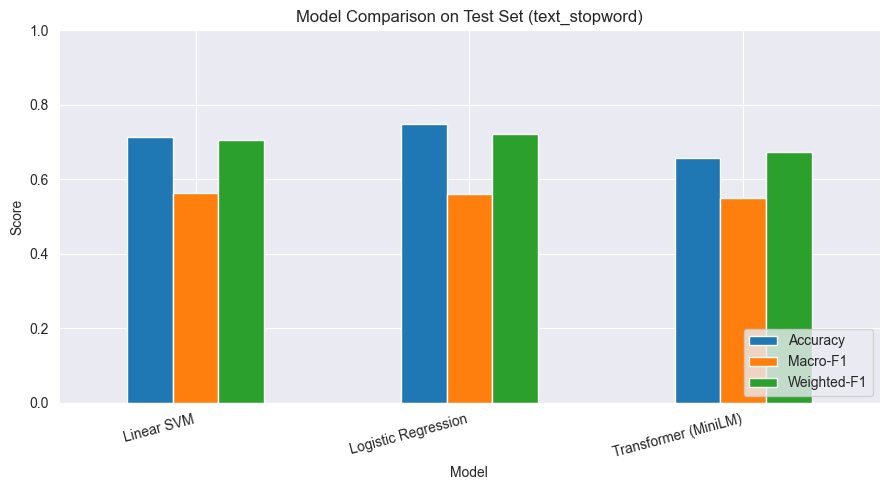

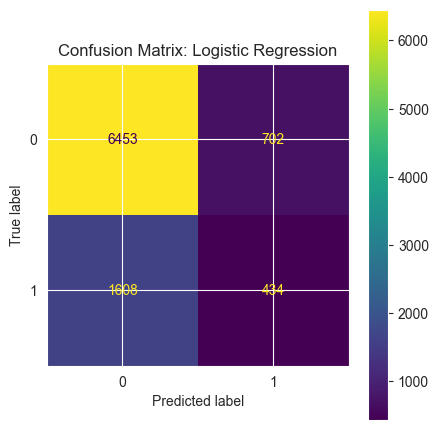

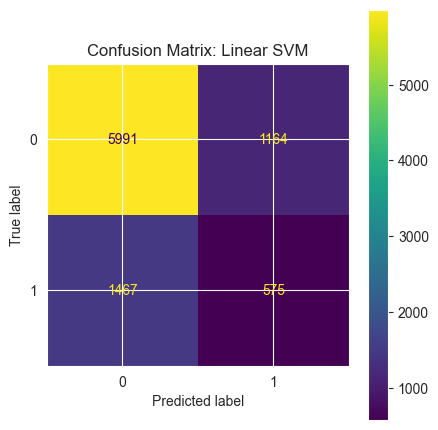

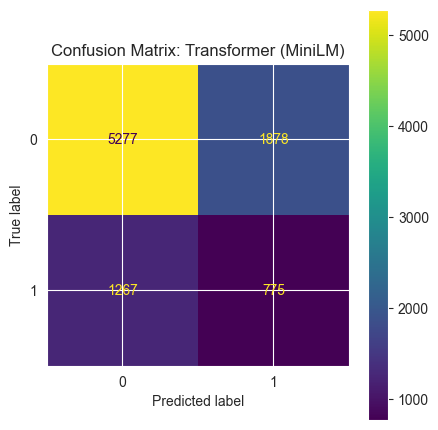


Error overlap summary (counts):
Logistic Regression     2310
Linear SVM              2631
Transformer (MiniLM)    3145
Any_Error               4250
dtype: int64

# cases Transformer correct & LR wrong: 754


In [7]:

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)


class_names = ["0", "1"]


def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

preds = {
    "Logistic Regression": y_pred_lr,
    "Linear SVM": y_pred_svm,
    "Transformer (MiniLM)": y_pred_minilm,
}

# Basic sanity check: all same length
n = len(y_test)
for name, p in preds.items():
    if len(p) != n:
        raise ValueError(f"{name}: y_pred length {len(p)} != y_test length {n}")

# Metrics table
rows = []
for name, y_pred in preds.items():
    row = {"Model": name, **compute_metrics(y_test, y_pred)}
    rows.append(row)

metrics_df = pd.DataFrame(rows).set_index("Model").sort_values("Macro-F1", ascending=False)
print(metrics_df)

for name, y_pred in preds.items():
    print("\n" + "="*70)
    print(name)
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


# Plot 1: Bar chart of key metrics
plot_metrics = metrics_df[["Accuracy", "Macro-F1", "Weighted-F1"]]

fig, ax = plt.subplots(figsize=(9, 5))
plot_metrics.plot(kind="bar", ax=ax)
ax.set_title("Model Comparison on Test Set (text_stopword)")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.legend(loc="lower right")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()


# Plot 2: Confusion matrices (one per model)
for name, y_pred in preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    disp.plot(ax=ax, values_format="d")
    ax.set_title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()


err = {}
for name, y_pred in preds.items():
    err[name] = (y_pred != y_test)

err_df = pd.DataFrame({k: v for k, v in err.items()})
err_df["Any_Error"] = err_df.any(axis=1)

print("\nError overlap summary (counts):")
print(err_df.sum())

# Example: cases where transformer is correct but LR is wrong
if "Transformer (MiniLM)" in preds and "Logistic Regression" in preds:
    transf_better = (~err["Transformer (MiniLM)"]) & (err["Logistic Regression"])
    print("\n# cases Transformer correct & LR wrong:", int(transf_better.sum()))
